# King County Housing analysis

## Getting started and Preparing Data

### Imports

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import datetime as dt
import numpy as np
import math
import psutil
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split

import plotly.express as px

%matplotlib inline
plt.style.use('seaborn')
np.random.seed(42)

### Explore Data

In [38]:
kc = pd.read_csv('King_County_House_prices_dataset.csv')

In [39]:
kc.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

In [6]:
kc.shape

(21597, 21)

what type of data?

In [8]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


what is missing?

In [9]:
missing = pd.DataFrame(kc.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/kc.shape[0]*100,1)
missing[missing.Number!=0]

Number  Percentage
waterfront      2376        11.0
view              63         0.3
yr_renovated    3842        17.8

Any categories? Few uniques hints on categories.

In [10]:
kc.nunique()

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

### Clean Data

In [24]:
kc.replace(to_replace=['?', ''], value='NaN', inplace=True)

In [25]:
kc.sqft_basement = kc.sqft_basement.astype(float)

Make log of price and change date to ordinal

In [48]:
kc['log_price'] = [math.log(float(p)) for p in kc.price]

In [27]:
kc['date'] = pd.to_datetime(kc['date'])
kc['date']=kc['date'].map(dt.datetime.toordinal)

Backup for later...

In [28]:
kc_backup = kc.copy()

scale data

In [29]:
continuous_var = list(kc.select_dtypes(
                        ['int64','float64','bool']).columns.values)
continuous_var.remove('id')
continuous_var.remove('waterfront')
continuous_var.remove('zipcode')
continuous_var.remove('lat')
continuous_var.remove('long')
categorical_var=['waterfront']

In [30]:
kc[continuous_var] = scaler.fit_transform(kc_backup[continuous_var])

### looking at some features

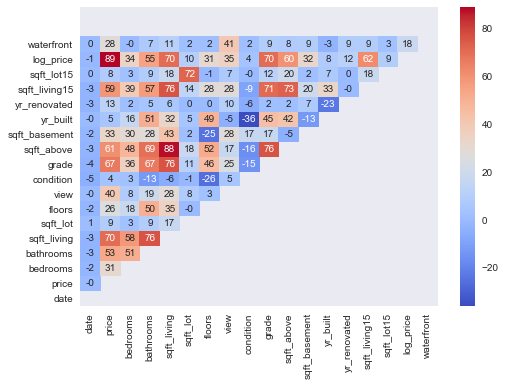

In [31]:
kc_dum=pd.get_dummies(kc[continuous_var+categorical_var].copy())
mask = np.triu(kc_dum.corr())
ax = sns.heatmap(round(kc_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')
ax.set_ylim((0,20))
plt.savefig('figures/correlogram.png')

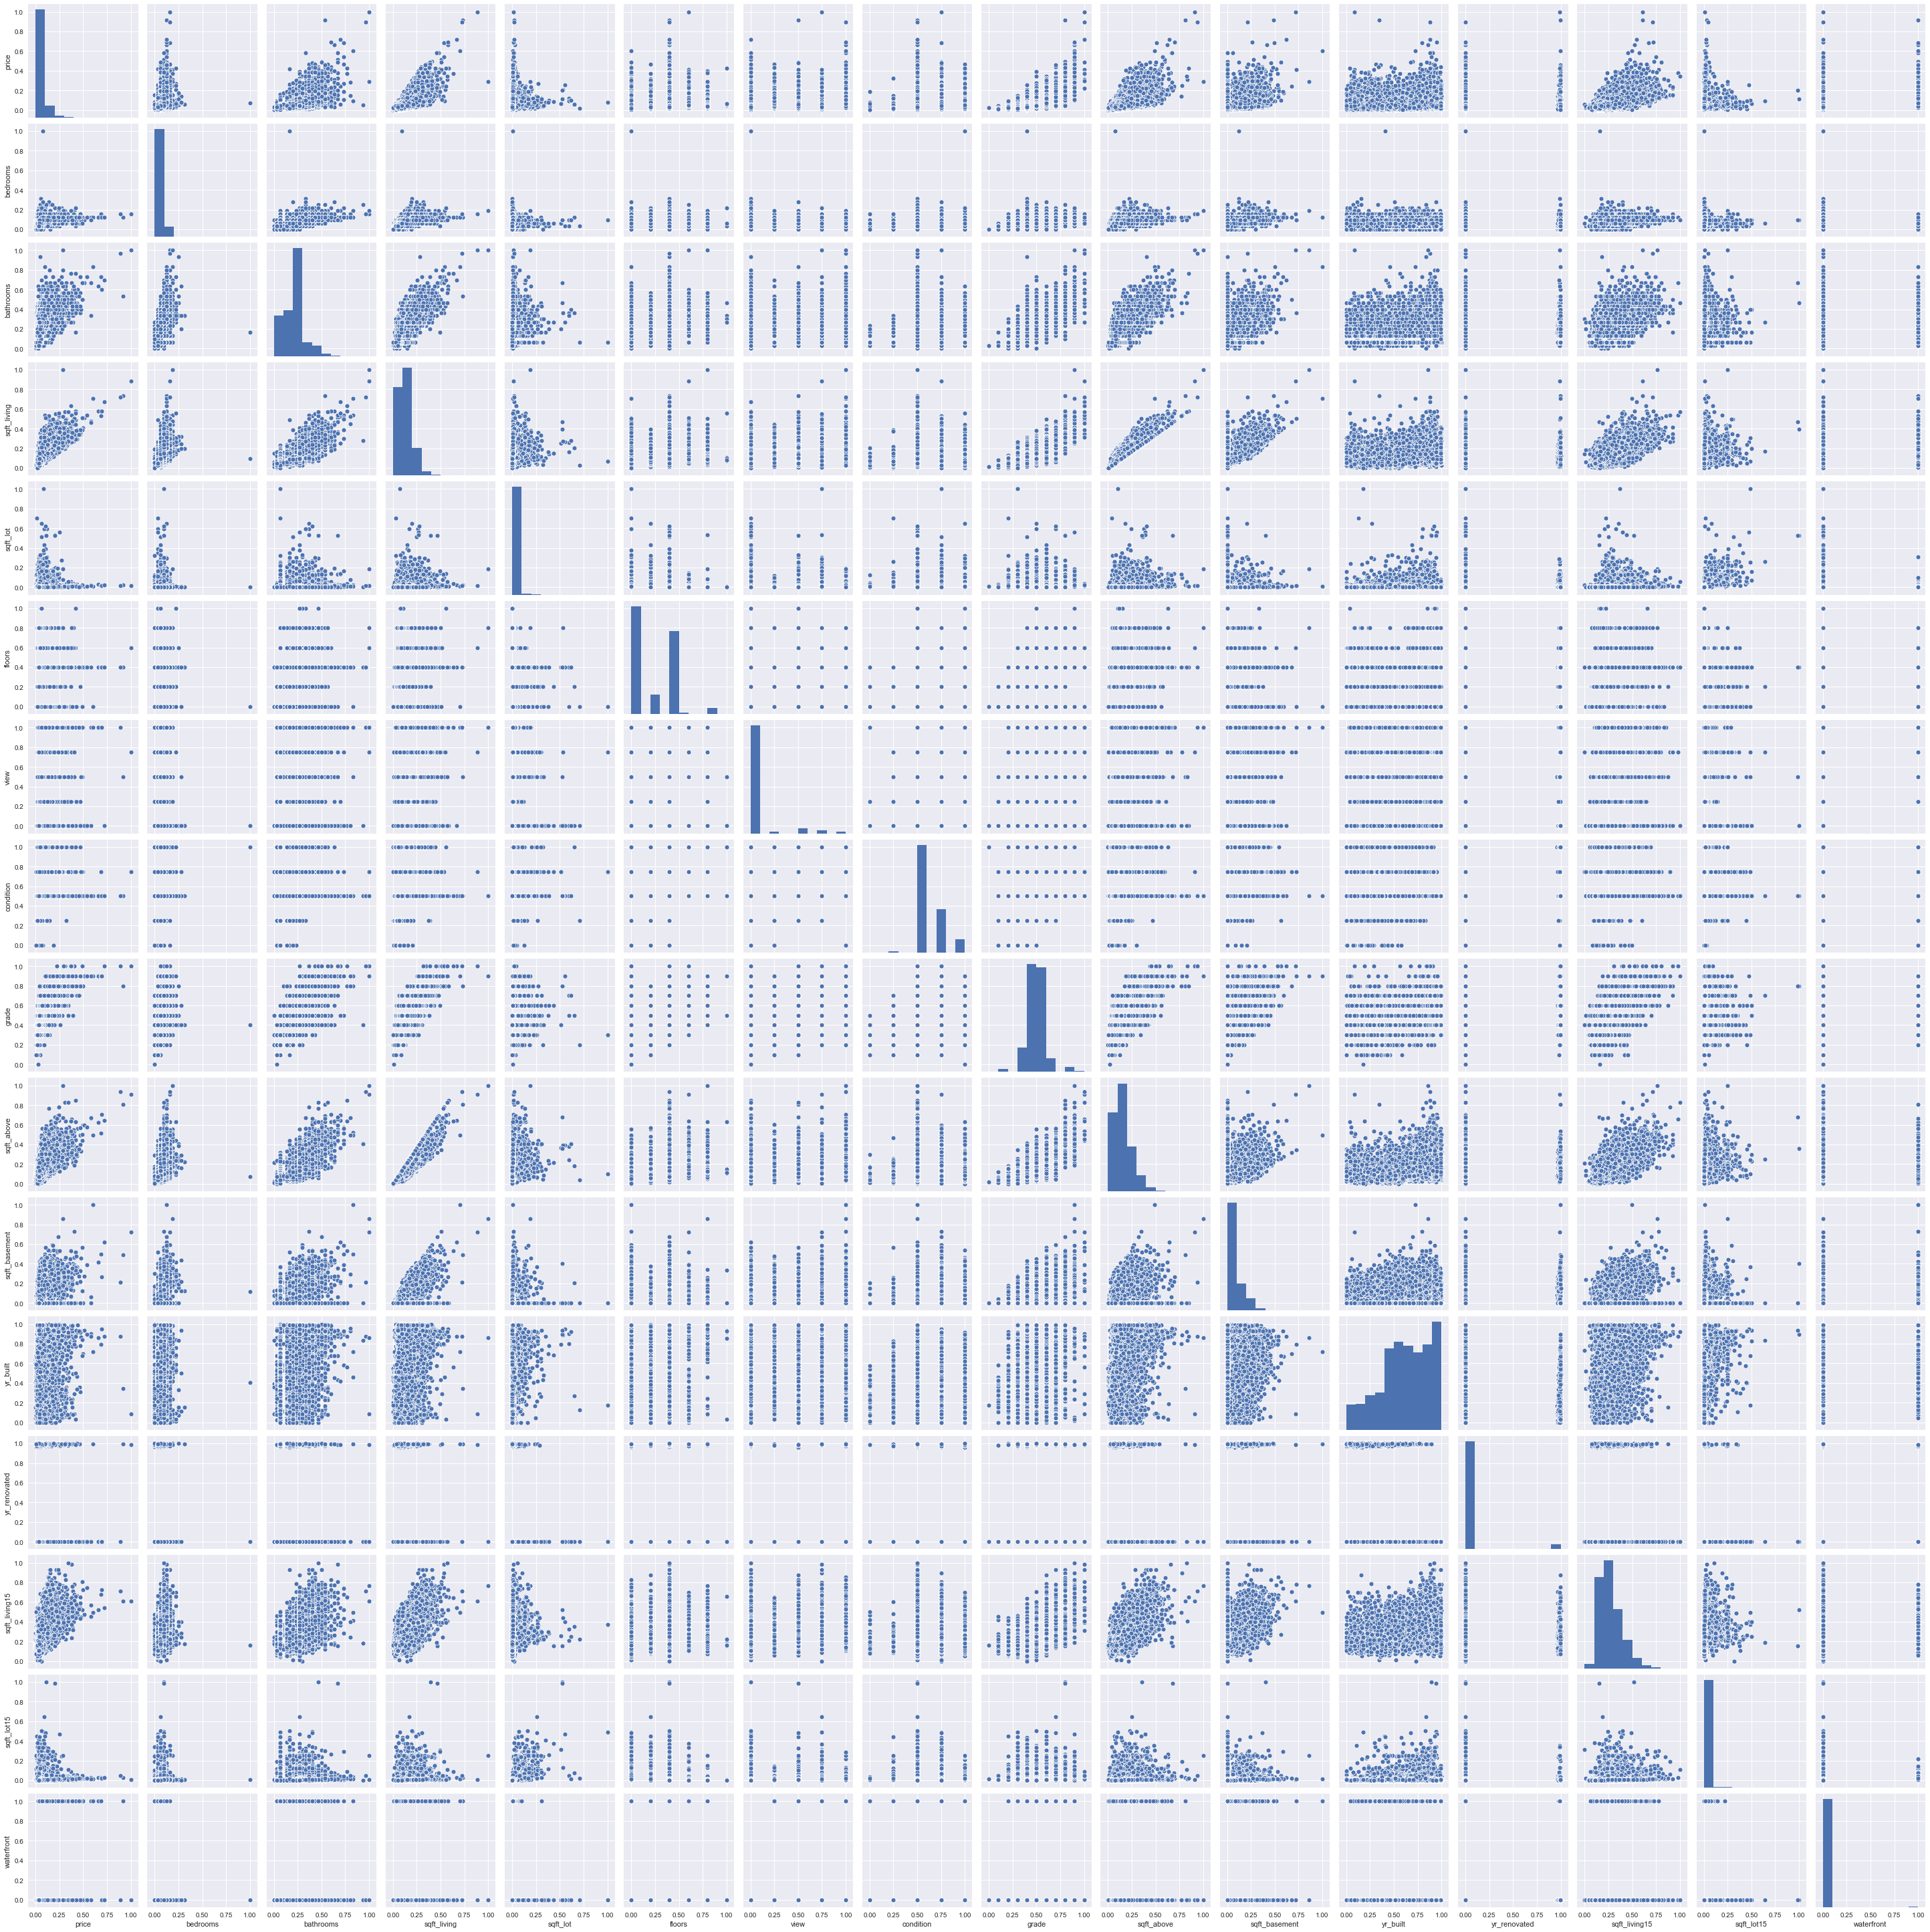

In [17]:
_ =sns.pairplot(kc_dum)
plt.savefig('figures/pairplot.png')

## Predicting the grade

In [49]:
X_train, X_test, y_train, y_test = train_test_split(kc[continuous_var + categorical_var], kc.grade, test_size=0.33, random_state=42, shuffle=False)

In [50]:
y = 'grade'
dsf = '''log_price +
sqft_living +
yr_built'''

ols_formula = f'{y} ~ + {dsf}'
model = smf.ols(formula=ols_formula, data = X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  grade   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:47:24   Log-Likelihood:                -13788.
No. Observations:               14469   AIC:                         2.758e+04
Df Residuals:                   14465   BIC:                         2.761e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -28.7804      0.469    -61.325      0.000     -29.700     -27.860
log_price       0.9103      0.014     64.538      0.000       0.883       0.938
sqft_living     0.0005   8.66e-06     57.610      0.000       0.000       0.001
yr_built        0.0119      0.000     58.703      0.000       0.012       0.012
==============================================================================
Omnibus:                      150.404   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.418
Skew:                           0.035   Prob(JB):                     9.35e-56
Kurtosis:                       3.644   Cond. No.                     2.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
grade_pred = model.predict(X_test)

In [52]:
X_test['grade_pred'] = grade_pred

In [53]:
fig = px.box(x = X_test.grade,
y = X_test.grade_pred)
fig.update_layout(title_text="Grade Prediction", xaxis_title = 'Grades', yaxis_title = 'Predicted Grades')
fig.write_image('figures/grade_prediction.png')
fig.show()

In [57]:
ols_formula = 'grade ~ grade_pred'
smf.ols(formula=ols_formula, data = X_test).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  grade   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                 1.830e+04
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:52:07   Log-Likelihood:                -6783.5
No. Observations:                7128   AIC:                         1.357e+04
Df Residuals:                    7126   BIC:                         1.358e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1041      0.057      1.816      0.069      -0.008       0.216
grade_pred     0.9833      0.007    135.277      0.000       0.969       0.998
==============================================================================
Omnibus:                      111.741   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.591
Skew:                           0.179   Prob(JB):                     3.00e-36
Kurtosis:                       3.650   Cond. No.                         61.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## population density by bedrooms

In [55]:
fig = px.density_mapbox(kc,
                        lat='lat',
                        lon='long',
                        z='bedrooms',
                        radius=5,
                        color_continuous_scale="electric" ,
                        center=dict(lat=47.53, lon=-122.23),
                        zoom=8.3,
                        mapbox_style="open-street-map")
fig.write_image("figures/map_price.png")
fig.show()

## extra cost for waterfront

In [40]:
kc_wf = kc_backup.copy()

In [41]:
kc_wf['price_per_sqft'] = kc_wf.price / kc_wf.sqft_living

In [42]:
kc_wf.groupby(['waterfront']).price_per_sqft.mean()

waterfront
0.0    262.502945
1.0    512.999999
Name: price_per_sqft, dtype: float64

In [43]:
kc_wf.groupby(['waterfront']).price_per_sqft.median()

waterfront
0.0    244.094488
1.0    516.994559
Name: price_per_sqft, dtype: float64